# setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/bnn-regression')

In [ ]:
%%capture
!pip install dm-haiku

In [ ]:
# use TPUs
# - https://github.com/google/jax/pull/8485/commits/61a3abbeab027d0b4ad868de1cbb6a542cd19c4a
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu('tpu_driver-0.1dev20211031')

# use float32 matmul on TPU
import jax
jax.config.update('jax_default_matmul_precision', 'highest')

# check the number of GPU / TPU devices
n_dev = jax.local_device_count() 
print('num. devices:', n_dev)

num. devices: 8


# imports

In [ ]:
# system imports
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# relative imports
from core import models, distributions, datasets, utils, metrics, spmd
from core.sgd import train_sgd, train_ensamble
from core.rwmh import rwmh_sampler
from core.hmc import hmc_sampler
from core.nuts import nuts_sampler
from core.spmd import spmd

In [ ]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

# dataset

In [ ]:
ds_path = 'naval_dataset/data.txt'
key = jax.random.PRNGKey(0)
(x_train, y_train), (x_test, y_test) = datasets.load_naval_dataset(ds_path, key)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(10740, 14) (10740,) (1194, 14) (1194,)


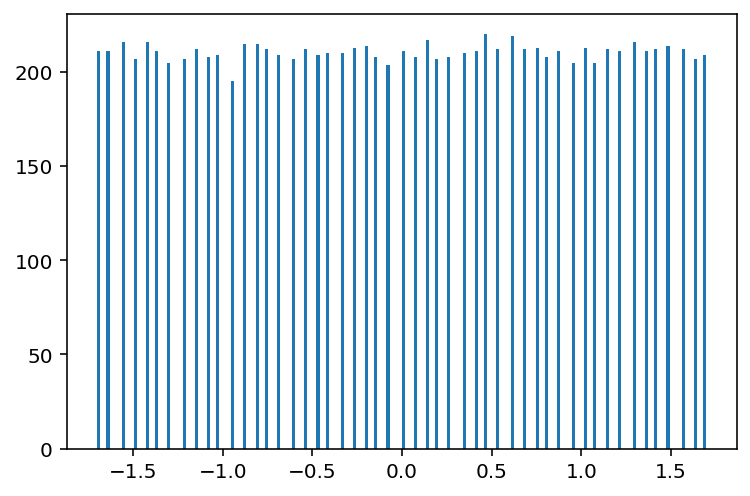

In [ ]:
plt.hist(y_train, bins=200)
plt.show()

# model

In [ ]:
# define model
key = jax.random.PRNGKey(0)
layer_dims = 3*[50]
prior_sd = 1
init_sd = 0.1
predict_fn, params_init = models.make_nn(key, x_train, layer_dims)
n_params = len(params_init)
params_init = init_sd*jax.random.normal(key, [n_params])
log_likelihood_fn = distributions.make_gaussian_log_likelihood(x_train, y_train, predict_fn)
log_prior_fn = distributions.make_gaussian_log_prior(prior_sd)
log_posterior_fn = distributions.make_log_posterior_fn(x_train, y_train, log_likelihood_fn, log_prior_fn)

In [ ]:
# test model
print('num. params: ', n_params)
print('PDF test: ', log_prior_fn(params_init), log_likelihood_fn(params_init, x_train, y_train))

num. params:  5952
PDF test:  -5498.814 -16371.821


# training

In [ ]:
# number of independent chains to create using each method
n_chains = 5

# number of samples to keep from each chain
n_samples = 100

# make dirs for storing output
os.makedirs('tmp', exist_ok=True)
os.makedirs('plots', exist_ok=True)

## SGD

In [ ]:
%%time
n_epochs = 100_000
lr_start = 1e-6
lr_stop = 1e-9
key = jax.random.PRNGKey(0)

chains_sgd = jnp.zeros([n_chains, 1, n_params])
for i in range(n_chains):
    key, _ = jax.random.split(key)
    params = init_sd*jax.random.normal(key, [n_params])
    params_sgd, loss_sgd = spmd(train_sgd)(x_train, y_train, params, log_likelihood_fn, log_prior_fn, n_dev, n_epochs, lr_start, lr_stop)
    chains_sgd = chains_sgd.at[i].set(params_sgd[None])

jnp.save('tmp/sgd.npy', chains_sgd)

CPU times: user 15.6 s, sys: 26.9 s, total: 42.5 s
Wall time: 1min 12s


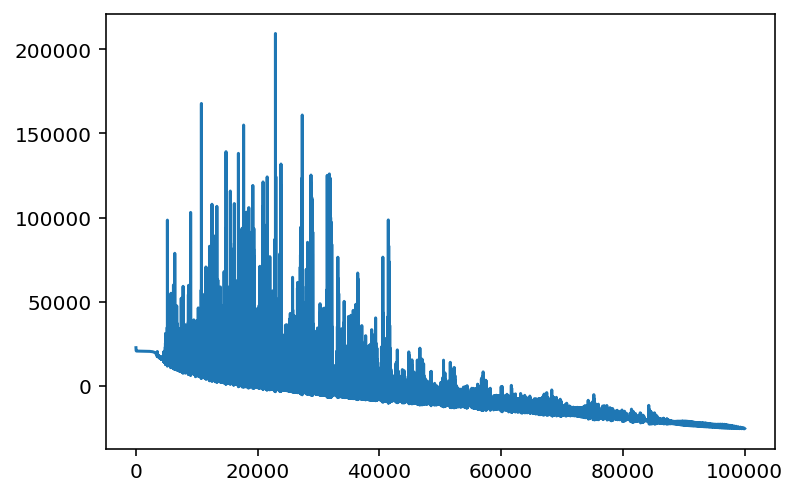

-25324.379


In [ ]:
fig, ax = plt.subplots()
ax.plot(loss_sgd)
plt.show()
print(loss_sgd[-1])

## ensamble

In [ ]:
%%time
ens_size = 10
key = jax.random.PRNGKey(0)

chains_ens = jnp.zeros([n_chains, ens_size, n_params])
for i in range(n_chains):
    key, _ = jax.random.split(key)
    params = init_sd*jax.random.normal(key, [ens_size, n_params])
    chain_ens, loss_history = spmd(train_ensamble)(x_train, y_train, params, log_likelihood_fn, log_prior_fn, n_dev, n_epochs, lr_start, lr_stop)
    chains_ens = chains_ens.at[i].set(chain_ens)

jnp.save('tmp/ens.npy', chains_ens)

CPU times: user 1min 14s, sys: 3min 22s, total: 4min 37s
Wall time: 8min


## RWMH

In [ ]:
%%time
step_size = 2e-5
n_blind_steps = 30_000
key = jax.random.PRNGKey(0)

chains_rwmh = jnp.zeros([n_chains, n_samples, n_params])
for i in range(n_chains):
    key, _ = jax.random.split(key)
    chain_rwmh, avg_accept_prob = spmd(rwmh_sampler)(x_train, y_train, chains_sgd[i, 0], log_likelihood_fn, log_prior_fn, n_dev, key, n_samples, n_blind_steps, step_size)
    chains_rwmh = chains_rwmh.at[i].set(chain_rwmh)
    print(f'Avg. accept. prob.: {avg_accept_prob.mean():.2%}')

jnp.save('tmp/rwmh.npy', chains_rwmh)

Avg. accept. prob.: 18.42%
Avg. accept. prob.: 15.94%
Avg. accept. prob.: 19.61%
Avg. accept. prob.: 15.63%
Avg. accept. prob.: 19.61%
CPU times: user 2min 36s, sys: 7min 30s, total: 10min 7s
Wall time: 17min 30s


## HMC

In [ ]:
%%time
hmc_step_size = 5e-7
n_leapfrog_steps = 10_000
key = jax.random.PRNGKey(0)

chains_hmc = jnp.zeros([n_chains, n_samples, n_params])
for i in range(n_chains):
    key, _ = jax.random.split(key)
    chain_hmc, avg_accept_prob = spmd(hmc_sampler)(x_train, y_train, chains_sgd[i, 0], log_likelihood_fn, log_prior_fn, n_dev, key, n_samples, n_leapfrog_steps, hmc_step_size)
    chains_hmc = chains_hmc.at[i].set(chain_hmc)
    print(f'Avg. accept. prob.: {avg_accept_prob.mean():.2%}')

jnp.save('tmp/hmc.npy', chains_hmc)

Avg. accept. prob.: 81.69%
Avg. accept. prob.: 80.29%
Avg. accept. prob.: 83.18%
Avg. accept. prob.: 77.03%
Avg. accept. prob.: 86.18%
CPU times: user 3min 25s, sys: 9min 25s, total: 12min 50s
Wall time: 22min 4s


## NUTS

In [ ]:
%%time
max_depth = 13
print('max leapfrog steps: ', 2**max_depth)
key = jax.random.PRNGKey(0)

chains_nuts = jnp.zeros([n_chains, n_samples, n_params])
for i in range(n_chains):
    key, _ = jax.random.split(key)
    chain_nuts, ratio_valid_samples, total_stops = spmd(nuts_sampler)(x_train, y_train, chains_sgd[i, 0], log_likelihood_fn, log_prior_fn, n_dev, key, n_samples, max_depth, hmc_step_size)
    chains_nuts = chains_nuts.at[i].set(chain_nuts)
    print(f'Proportion valid: {ratio_valid_samples.mean():.2%}')
    print(f'Termination: max_steps={total_stops[0]}, u-turn={total_stops[1]}, max_error={total_stops[2]}.')

jnp.save('tmp/nuts.npy', chains_nuts)

max leapfrog steps:  8192
Proportion valid: 98.68%
Termination: max_steps=100, u-turn=0, max_error=0.
Proportion valid: 99.10%
Termination: max_steps=100, u-turn=0, max_error=0.
Proportion valid: 97.75%
Termination: max_steps=100, u-turn=0, max_error=0.
Proportion valid: 99.08%
Termination: max_steps=100, u-turn=0, max_error=0.
Proportion valid: 97.93%
Termination: max_steps=100, u-turn=0, max_error=0.
CPU times: user 3min 52s, sys: 10min 40s, total: 14min 32s
Wall time: 24min 53s


# load training output

In [33]:
chains_sgd = jnp.load('tmp/sgd.npy', allow_pickle=True)
chains_ens = jnp.load('tmp/ens.npy', allow_pickle=True)
chains_rwmh = jnp.load('tmp/rwmh.npy', allow_pickle=True)
chains_hmc = jnp.load('tmp/hmc.npy', allow_pickle=True)
chains_nuts = jnp.load('tmp/nuts.npy', allow_pickle=True)

# diagnostics

In [34]:
burn_in = 20
chains_rwmh = chains_rwmh[:, burn_in:]
chains_hmc = chains_hmc[:, burn_in:]
chains_nuts = chains_nuts[:, burn_in:]

chains_dict = {
    'sgd': chains_sgd,
    'ensamble': chains_ens,
    'rwmh': chains_rwmh,
    'hmc': chains_hmc,
    'nuts': chains_nuts,
}

for name, chain in chains_dict.items():
    print(name, chain.shape)

sgd (5, 1, 5952)
ensamble (5, 10, 5952)
rwmh (5, 80, 5952)
hmc (5, 80, 5952)
nuts (5, 80, 5952)


## history of a single parameter

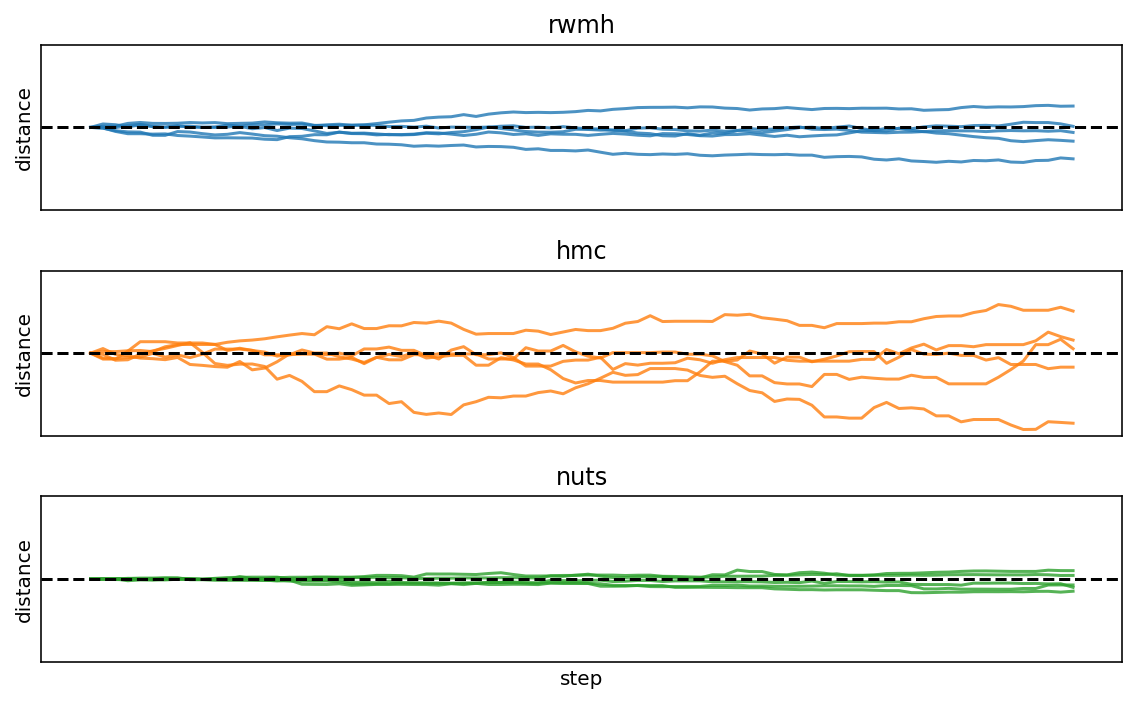

In [35]:
param_idx = 0
n_points = 100
y_range = 0.08
fig, axs = plt.subplots(3, 1, figsize=[8, 5])
axs = axs.flatten()
chains_to_show = ['rwmh', 'hmc', 'nuts']
for i, name in enumerate(chains_to_show):
    chains = chains_dict[name]
    for j in range(n_chains):
        y = chains[j, :n_points, param_idx]
        y -= y[0]
        axs[i].plot(y, '-', alpha=0.8, color=f'C{i}')
    axs[i].axhline(y=0, linestyle="--", color='black')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_ylim([-y_range, y_range])
    axs[i].set_ylabel('distance')
    axs[i].set_title(name)
    if i == 2: axs[i].set_xlabel('step')
plt.tight_layout()
plt.savefig('plots/uci_param_history.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## autocorrelation

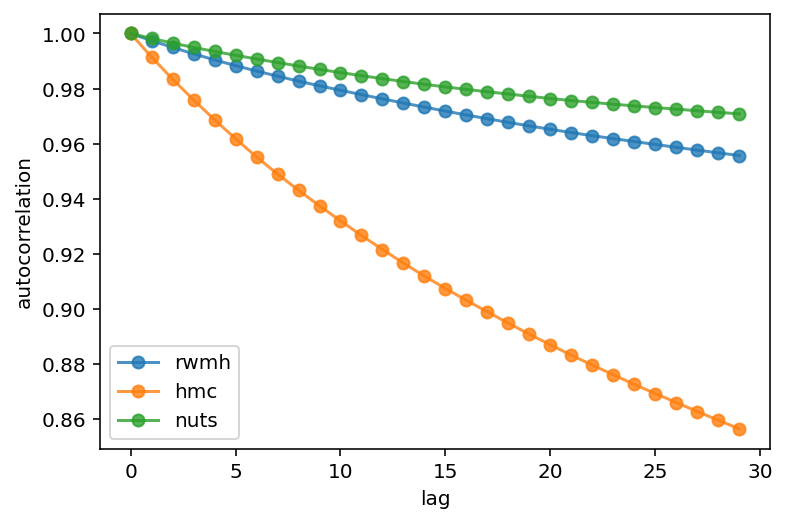

In [36]:
fig, ax = plt.subplots()
n_lags = 30

# autocorrelation
chains_to_show = ['rwmh', 'hmc', 'nuts']
for i, name in enumerate(chains_to_show):
    chains = chains_dict[name]
    r = metrics.autocorr(chains, n_lags)
    ax.plot(r, 'o-', alpha=0.8, label=name)
    # ax.axhline(y=0, color='black', linestyle="--")

ax.legend()
ax.set_xlabel('lag')
ax.set_ylabel('autocorrelation')
plt.savefig('plots/uci_param_autocor.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## stdev of params

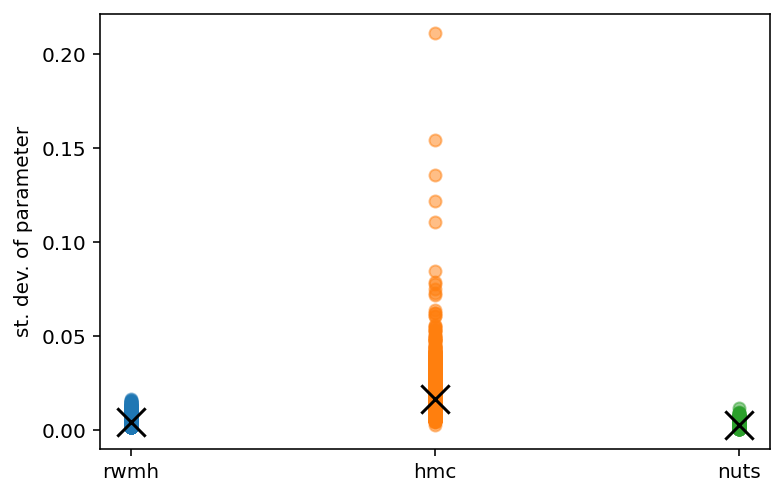

In [37]:
fig, ax = plt.subplots()

# R_hat
chains_to_show = ['rwmh', 'hmc', 'nuts']
for i, name in enumerate(chains_to_show):
    chains = chains_dict[name]
    chain = chains[0]
    r = chain.std(axis=0)
    ax.scatter([i]*len(r), r, alpha=0.5)
    ax.scatter(i, r.mean(), color='black', marker='x', s=200, zorder=2)
ax.set_xticks(range(len(chains_to_show)))
ax.set_xticklabels(chains_to_show)
ax.set_ylabel('st. dev. of parameter')

plt.savefig('plots/uci_param_stdev.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## calibration

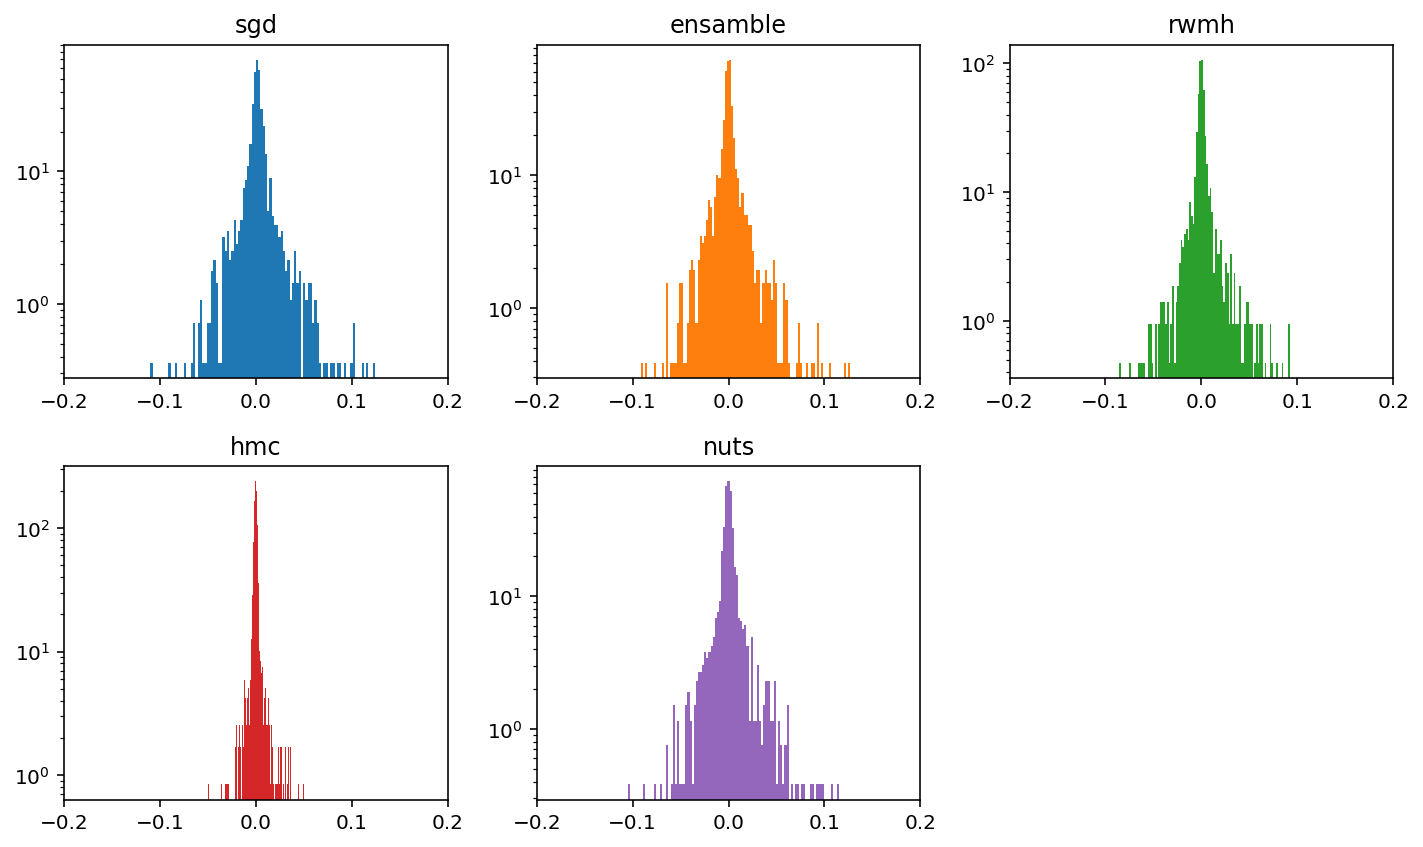

In [38]:
# residuals
def get_std_resid(chain):
    # average y_hat across nodes
    predict_vmap = jax.vmap(predict_fn, [None, 0])
    y_hat = predict_vmap(x_test, chain).mean(0)
    mean, std = y_hat[:, 0], y_hat[:, 1]

    # compute residuals
    std_resid = (y_test - mean)

    return std_resid

fig, axs = plt.subplots(2, 3, figsize=[10, 6])
axs = axs.flatten()
for i, (name, chains) in enumerate(chains_dict.items()):
    chain = chains.reshape([-1, n_params])
    std_resid = get_std_resid(chain)
    axs[i].hist(std_resid.tolist(), bins=100, density=True, color=f'C{i}')
    axs[i].set_xlim([-0.2, 0.2])
    axs[i].set_yscale('log')
    axs[i].set_title(name)

axs[-1].axis('off')
plt.tight_layout()
plt.savefig('plots/uci_residuals_hist.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

In [39]:
# p-values of residuals
def get_resid_pvals(key, chain, n_samples=10_000):
    n_samples_per_step = n_samples // len(chain)
    
    # generate samples
    def sample_from_node(key, params):
        y_hat = predict_fn(x_test, params)
        mean = y_hat[:, 0]
        std = y_hat[:, 1]
        samples = mean[:, None] + std[:, None] * jax.random.normal(key, [len(x_test), n_samples_per_step])
        return samples
    keys = jax.random.split(key, len(chain))
    samples = jax.vmap(sample_from_node)(keys, chain) # [len(chain), len(x_test), n_samples_per_step]
    samples = samples.transpose([1, 0, 2]).reshape([len(x_test), n_samples])
    
    # get quantiles of the residuals
    quantiles = (samples < y_test[:, None]).mean(1)
    
    return quantiles

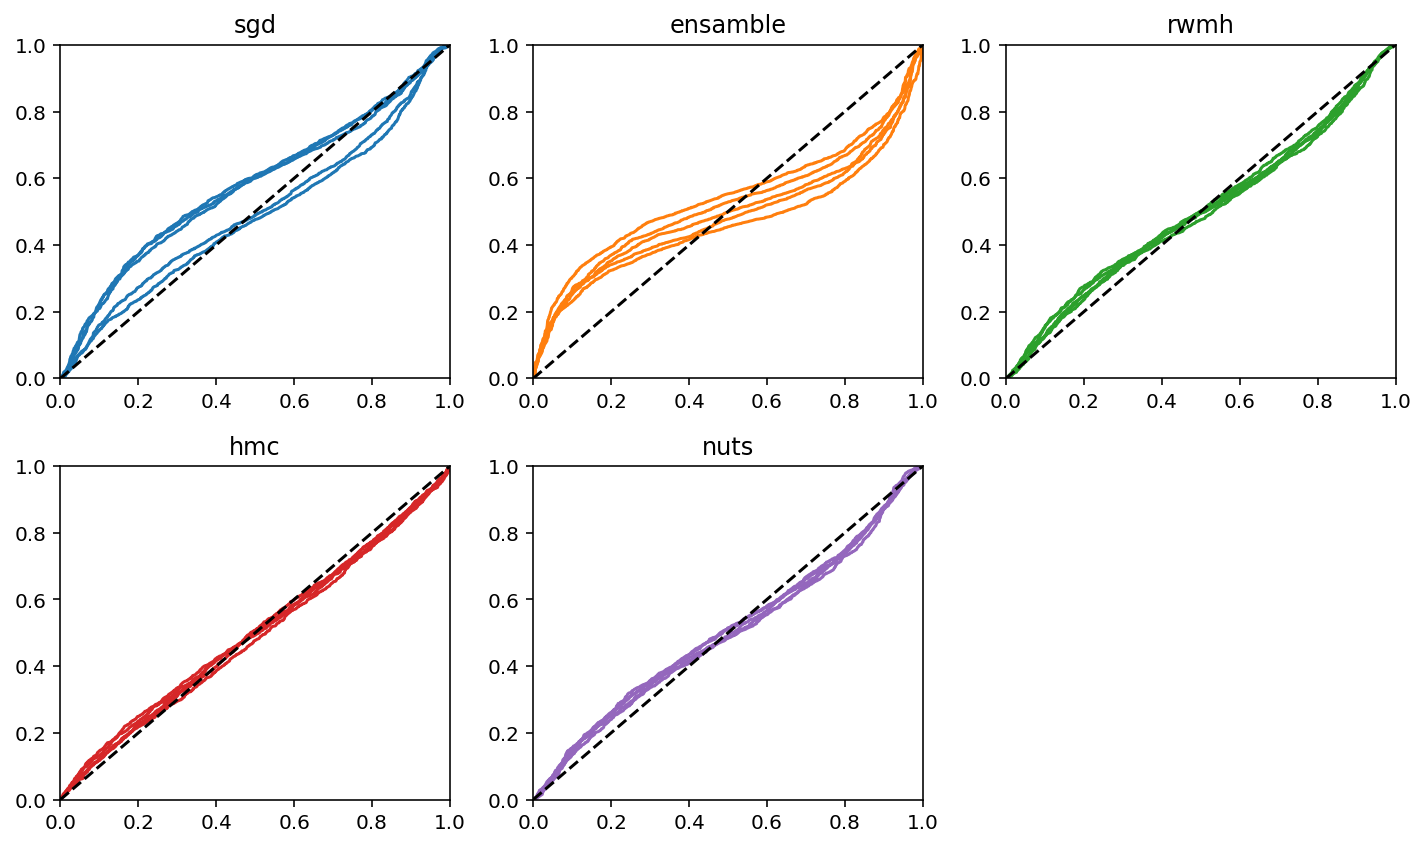

In [40]:
fig, axs = plt.subplots(2, 3, figsize=[10, 6])
axs = axs.flatten()
key = jax.random.PRNGKey(0)
for i, (name, chains) in enumerate(chains_dict.items()):   
    keys = jax.random.split(key, n_chains)
    pvals = jax.pmap(get_resid_pvals)(keys, chains)
    for j in range(n_chains):
        axs[i].plot(jnp.linspace(0, 1, len(y_test)), jnp.sort(pvals[j]), label=name, color=f'C{i}')
    axs[i].plot([0, 1], [0, 1], c='black', ls='--')
    axs[i].set_xlim([0, 1])
    axs[i].set_ylim([0, 1])
    axs[i].set_title(name)

axs[-1].axis('off')
plt.tight_layout()
plt.savefig('plots/uci_residuals_pvals.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## Brier score

In [41]:
for i, (name, chains) in enumerate(chains_dict.items()):
    
    def mse_fn(chain):
        # average y_hat across nodes
        predict_vmap = jax.vmap(predict_fn, [None, 0])
        y_hat = predict_vmap(x_test, chain).mean(0)
        mean, std = y_hat[:, 0], y_hat[:, 1]
        
        # compute mean error
        mse = ((y_test - mean)**2)
        return mse
    
    chain = chains.reshape([-1, n_params])
    mse = mse_fn(chain)
    print(f'{name}, {mse.mean():.5f} ± {mse.std():.5f}')

sgd, 0.00040 ± 0.00128
ensamble, 0.00036 ± 0.00118
rwmh, 0.00023 ± 0.00079
hmc, 0.00004 ± 0.00018
nuts, 0.00034 ± 0.00111


## Likelihood of test data

In [42]:
def chain_to_loglike(chain):
    # compute y_hat for each node in the chain
    likelihood_vmap = jax.vmap(log_likelihood_fn, [0, None, None])
    log_likelihood = likelihood_vmap(chain, x_test, y_test)

    # average the likelihood across nodes
    log_likelihood = jax.scipy.special.logsumexp(log_likelihood, 0) - jnp.log(len(chain))

    # get total likelihood of all data points
    log_likelihood = log_likelihood.sum()
    return log_likelihood

for i, (name, chains) in enumerate(chains_dict.items()):
    lp = jax.vmap(log_prior_fn)(chain).mean()
    ll = jax.pmap(chain_to_loglike)(chains)
    # print(f'{name:<8}: prior={lp:.0f}, likelihood={ll:.0f}')
    print(f'{name}: {ll.mean():.3f} ± {ll.std():.4f}')

sgd: 3408.531 ± 52.6291
ensamble: 3508.975 ± 33.1368
rwmh: 4215.791 ± 84.5944
hmc: 5856.526 ± 83.3340
nuts: 3746.374 ± 115.7755


## Distribution of parameters

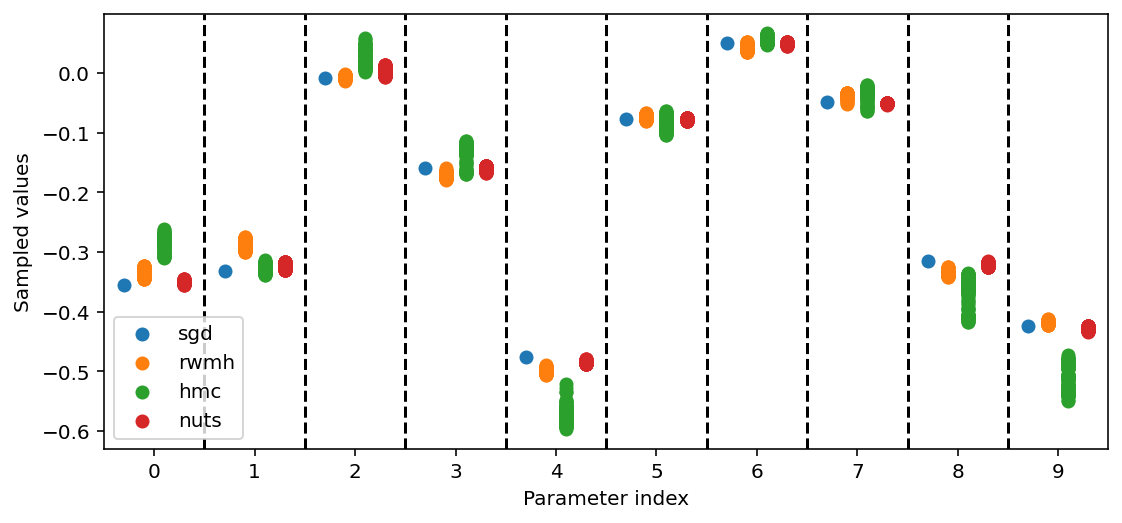

In [43]:
fig, ax = plt.subplots(figsize=[9, 4])
d = 10 # num. of params to plot
chains_to_show = ['sgd', 'rwmh', 'hmc', 'nuts']
for i, name in enumerate(chains_to_show):
    chains = chains_dict[name]
    chain = chains[0]
    y_ = chain[:, :d]
    x_ = jnp.zeros([len(y_), 1]) + jnp.arange(d)[None] + (0.2*i - 0.3)
    ax.scatter(x_, y_, c=f'C{i}', alpha=1, label=name)

for i in range(d-1):
    ax.axvline(x=i+0.5, linestyle="--", color='black')

ax.set_xlim([-0.5, d-0.5])
ax.set_xticks(range(d))
ax.set_xlabel('Parameter index')
ax.set_ylabel('Sampled values')
ax.legend(loc='lower left')
plt.savefig('plots/uci_param_distribution.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

## loss geometry

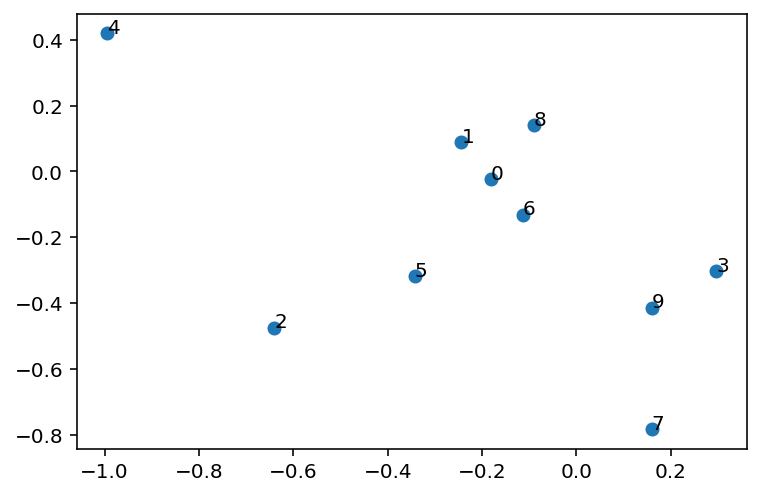

In [44]:
# show that independent sgd solutions differ in weights
# - pick 2 parameters and plots their values for each solution
param_idxs = [0, 1]
xy = chains_ens[0, :, param_idxs]
plt.scatter(xy[0, :], xy[1, :])
for i in range(xy.shape[1]):
    plt.annotate(str(i), (xy[0, i], xy[1, i]))
plt.show()

In [45]:
# test: loss when averaging solutions
sol_idxs = [0, 1, 2]
s0, s1, s2 = chains_ens[0, sol_idxs, :]
sa0 = (s0 + s1) / 2
sa1 = (s0 + s2) / 2
sa2 = (s1 + s2) / 2
sa3 = (s0 + s1 + s2) / 3
r = 0.5*jax.random.normal(key, s0.shape)
for s in [s0, s1, s2, sa0, sa1, sa2, sa3, r]:
    print(log_likelihood_fn(s, x_test, y_test))

3468.643
3448.2295
3409.8103
-201863.23
-76780.164
-62559.457
-50728.066
-8.069921e+29


In [46]:
%%time
# pick 3 sgd solutions
sol_idxs = [0, 1, 2]
s0, s1, s2 = chains_ens[0, sol_idxs, :]

# grid of (x, y) coordinates
n_points = 100
m = 0.2
x = jnp.linspace(-1-m, 1+m, n_points)
y = jnp.linspace(-m, 1+m, n_points)

# grid of coordinates in params space
sm = (s0 + s1)/2
dx = s1 - sm
dy = s2 - sm
params_grid = sm[None, None, :] + x[:, None, None]*dx[None, None, :] + y[None, :, None]*dy[None, None, :]
params_flat = params_grid.reshape([-1, n_params])

# evaluate loss at at each point in the grid
loss_fn = log_posterior_fn
loss_flat = jax.lax.map(log_posterior_fn, params_flat)
loss_grid = loss_flat.reshape([n_points, n_points])

CPU times: user 696 ms, sys: 993 ms, total: 1.69 s
Wall time: 2.62 s


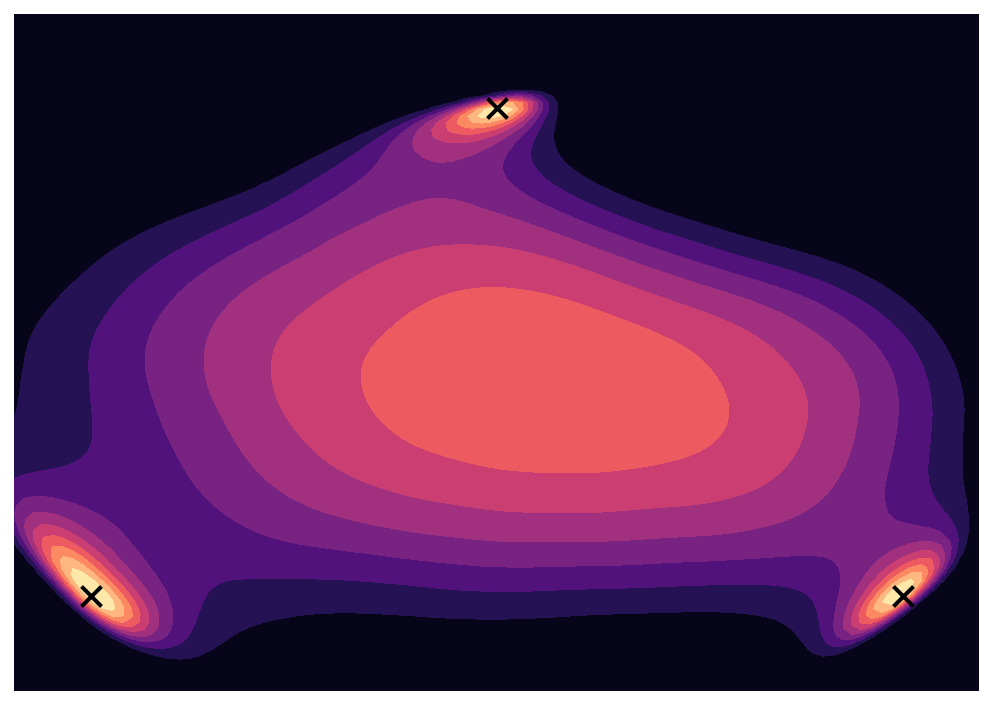

In [47]:
# map z to [0, 1]
scale = 1000
z = loss_grid
z = (z - z.max()) # [min, 0]
z = (-scale/jnp.min(z)) * z # [scale, 0]
z = jnp.exp(scale*z) # [0, 1]

fig, ax = plt.subplots(figsize=[7, 5])
extent = [-1-m, 1+m, -m, 1+m]
# ax.imshow(z.T, cmap='magma', aspect=0.8, origin='lower')
ax.contourf(z.T, cmap='magma', levels=10, origin='lower', extent=extent)
ax.scatter([-1, 1, 0], [0, 0, 1], marker='x', c='black', s=100, linewidth=2)
ax.axis('off')
plt.tight_layout()
plt.savefig('plots/loss_landscape.pdf', bbox_inches='tight', pad_inches=0)
plt.show()